In [1]:
import pandas as pd 
import numpy as np 
import hssm 
import matplotlib.pyplot as plt 
import pytensor 
import arviz as az 
import jax
import jax.extend
import hddm_wfpt
import bambi as bmb
#import blackjax
import seaborn as sns
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.api as sm
from statsmodels.formula.api import ols

%matplotlib inline
%config InlineBackend.figure_format='retina'

hssm.set_floatX("float32")
pytensor.config.floatX = "float32"

Setting PyTensor floatX type to float32.
Setting "jax_enable_x64" to False. If this is not intended, please set `jax` to False.


In [20]:
# Read in the data
pcs_vs = pd.read_csv(r'C:\Users\Halee\Downloads\subj_data.txt', delimiter = "\t")
pcs_vs.head()


,subjid,prolific_id,age,sex,promis_score,ExperimentID,task,ztype,rt,resp,display,choice,cond
0,00dxr2cv,63f77b2aa0d776f479dad4e8,22,Male,10.0,115124,Visual Search Task - 2,response_keyboard,0.2432,1,Trials,large,Absent
1,00dxr2cv,63f77b2aa0d776f479dad4e8,22,Male,10.0,115124,Visual Search Task - 2,response_keyboard,0.2261,1,Trials,large,Present
2,00dxr2cv,63f77b2aa0d776f479dad4e8,22,Male,10.0,115124,Visual Search Task - 2,response_keyboard,0.2149,0,Trials,large,Absent
3,00dxr2cv,63f77b2aa0d776f479dad4e8,22,Male,10.0,115124,Visual Search Task - 2,response_keyboard,0.5069,1,Trials,large,Absent
4,00dxr2cv,63f77b2aa0d776f479dad4e8,22,Male,10.0,115124,Visual Search Task - 2,response_keyboard,0.8334,1,Trials,small,Absent


In [ ]:
# Update IDs to start from 1
from collections import defaultdict
 
# initializing list
id_list = pcs_vs['subjid']
#print(id_list)
 
# using list comprehension + defaultdict + lambda
# assigning ids to values
temp = defaultdict(lambda: len(temp))
id_relabel = [temp[id] for id in id_list]
 
# print result
#print(id_relabel)


In [ ]:
# Add one to id list to it starts at 1
pcs_vs['participant_id'] = pd.to_numeric(id_relabel)+1


In [21]:
# Rename columns to fit library requirements
pcs_vs = pcs_vs.rename(columns={"resp": "response"})

# Update accuracy to -1(incorrect), 1(correct)
pcs_vs['response'] = pcs_vs['response'].apply(lambda x: 1 if x == 1 else -1)



In [22]:
# Filter dataset to absent condition only
pcs_vs_ab = pcs_vs.loc[(pcs_vs['cond'] == "Absent") & (pcs_vs['choice'] == 'large')]

# Examine dataframe for analysis
pcs_vs_ab.head(15)

,subjid,prolific_id,age,sex,promis_score,ExperimentID,task,ztype,rt,response,display,choice,cond
0,00dxr2cv,63f77b2aa0d776f479dad4e8,22,Male,10.0,115124,Visual Search Task - 2,response_keyboard,0.2432,1,Trials,large,Absent
2,00dxr2cv,63f77b2aa0d776f479dad4e8,22,Male,10.0,115124,Visual Search Task - 2,response_keyboard,0.2149,-1,Trials,large,Absent
3,00dxr2cv,63f77b2aa0d776f479dad4e8,22,Male,10.0,115124,Visual Search Task - 2,response_keyboard,0.5069,1,Trials,large,Absent
13,04md12ua,27,68,Male,8.0,124312,Visual Search Task - 2,response_keyboard,1.9860,1,Trials,large,Absent
18,04md12ua,27,68,Male,8.0,124312,Visual Search Task - 2,response_keyboard,1.2960,1,Trials,large,Absent
21,04md12ua,27,68,Male,8.0,124312,Visual Search Task - 2,response_keyboard,1.1980,1,Trials,large,Absent
38,05mmpi4t,63ed0065eb23ac3ee1726453,24,Male,8.0,115124,Visual Search Task - 2,response_keyboard,2.2142,1,Trials,large,Absent
45,05mmpi4t,63ed0065eb23ac3ee1726453,24,Male,8.0,115124,Visual Search Task - 2,response_keyboard,2.0710,1,Trials,large,Absent
50,05mmpi4t,63ed0065eb23ac3ee1726453,24,Male,8.0,115124,Visual Search Task - 2,response_keyboard,1.9409,1,Trials,large,Absent
63,0c3nco9z,63b6cc23f13731158517f900,39,Female,19.0,115124,Visual Search Task - 2,response_keyboard,1.5104,1,Trials,large,Absent


In [23]:
pcs_vs_ab.shape

(2135, 13)

# Splitting Data into Scores Based on Scores: Minimum Score 8, Maximum Score 40

## None: Scores of 8 which means reporting no brain fog symptoms whatsoever

In [24]:
# None Data
vs_none = pcs_vs_ab.loc[(pcs_vs_ab['promis_score'] == 8)]

In [25]:
vs_none.shape

(450, 13)

## Normal: Scores of 9-13 

In [26]:
# Normal Data
vs_norm = pcs_vs_ab.loc[(pcs_vs_ab['promis_score'] <= 13) & (pcs_vs_ab['promis_score'] > 8)]

In [27]:
vs_norm.shape

(368, 13)

## Mild: Scores of 14 - 18 

In [28]:
# Mild Data
vs_mild = pcs_vs_ab.loc[(pcs_vs_ab['promis_score'] <= 18) & (pcs_vs_ab['promis_score'] > 13)]

In [29]:
vs_mild.shape

(391, 13)

## Moderate: Scores of 19 - 23

In [30]:
# Moderate Data
vs_mod = pcs_vs_ab.loc[(pcs_vs_ab['promis_score'] <= 23) & (pcs_vs_ab['promis_score'] > 18)]

In [31]:
vs_mod.shape

(404, 13)

## Severe: Scores of 24 - 40

In [32]:
# Severe Data
vs_sev = pcs_vs_ab.loc[(pcs_vs_ab['promis_score'] <= 40) & (pcs_vs_ab['promis_score'] > 23)]

In [33]:
vs_sev.shape

(519, 13)

# Chi-Square Test for Group/Sex and ANOVA for Group/Age

In [34]:
# Define the score intervals and corresponding labels for the groups
score_bins = [0, 9, 14, 19, 24, 41]
group_labels = ['none', 'norm', 'mild', 'mod', 'sev']

# Add a new column to the original data based on the score intervals
pcs_vs_ab['group'] = pd.cut(pcs_vs_ab['promis_score'], bins=score_bins, labels=group_labels, right=False)

# Display the modified data with the added 'group' column
pcs_vs_ab['group'].value_counts()

C:\Users\halee\AppData\Local\Temp\ipykernel_40376\2987989055.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pcs_vs_ab['group'] = pd.cut(pcs_vs_ab['promis_score'], bins=score_bins, labels=group_labels, right=False)


group
sev     519
none    450
mod     404
mild    391
norm    368
Name: count, dtype: int64

In [35]:
from scipy.stats import chi2_contingency

contingency_table = pd.crosstab(pcs_vs_ab['group'], pcs_vs_ab['sex'])

# Perform chi-square test
chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)

# Print results
print("Chi-square statistic:", chi2_stat)
print("P-value:", p_val)
print("Degrees of freedom:", dof)
print("Expected frequencies:")
print(expected)

Chi-square statistic: 30.09387033403129
P-value: 4.683722814837355e-06
Degrees of freedom: 4
Expected frequencies:
[[194.18386492 255.81613508]
 [158.79924953 209.20075047]
 [168.72420263 222.27579737]
 [174.33395872 229.66604128]
 [223.9587242  295.0412758 ]]


In [36]:
from scipy.stats import f_oneway

# Perform one-way ANOVA
anova_results = f_oneway(pcs_vs_ab[pcs_vs_ab['group'] == 'none']['age'],
                         pcs_vs_ab[pcs_vs_ab['group'] == 'norm']['age'],
                         pcs_vs_ab[pcs_vs_ab['group'] == 'mild']['age'],
                         pcs_vs_ab[pcs_vs_ab['group'] == 'mod']['age'],
                         pcs_vs_ab[pcs_vs_ab['group'] == 'sev']['age'])

# Print results
print("ANOVA F-value:", anova_results.statistic)
print("ANOVA p-value:", anova_results.pvalue)

ANOVA F-value: 9.994652626257874
ANOVA p-value: 5.17168355311702e-08


# Hierarchical Modeling: Controlling for Individual Differences

In [ ]:
# Run Model
#model_hierarchical = hssm.HSSM(data=pcs_vs_ab, hierarchical=True, prior_settings="safe")
#model_hierarchical
#model_hierarchical.graph()
#model_hierarchical.sample()
#model_hierarchical.summary()

#model_hierarchical.plot_trace()


# Linear Ballistic Accumulator Modeling: Looking at Group Level Differences among Clinical Cutoffs: Extracting a, v, z, t parameters by group

In [ ]:
#lba_all = hssm.HSSM(data=pcs_vs_ab, model="ddm", include=[ 
#    {"name": "v",
#     "formula": "v ~ 1 + promis_score",
#     "link": "identity"
#    },
#    {"name": "a",
#     "formula": "a ~ 1 + promis_score",
#     "link": "identity"
#    },
#    {"name": "t",
#     "formula": "t ~ 1 + promis_score",
#     "link": "identity"
#    },
#    {"name": "z",
#     "formula": "z ~ 1 + promis_score",
#     "link": "identity"},
#],)
#print(lba_all)

## "None" Scores LBA Model Setup

In [83]:
lba_none = hssm.HSSM(data=vs_none)
print(lba_none)

Hierarchical Sequential Sampling Model
Model: ddm

Response variable: rt,response
Likelihood: analytical
Observations: 450

Parameters:

v:
    Prior: Normal(mu: 0.0, sigma: 2.0)
    Explicit bounds: (-inf, inf)
a:
    Prior: HalfNormal(sigma: 2.0)
    Explicit bounds: (0.0, inf)
z:
    Prior: Uniform(lower: 0.0, upper: 1.0)
    Explicit bounds: (0.0, 1.0)
t:
    Prior: HalfNormal(sigma: 2.0, initval: 0.10000000149011612)
    Explicit bounds: (0.0, inf)

Lapse probability: 0.05
Lapse distribution: Uniform(lower: 0.0, upper: 10.0)


## Run model on sample with scores of "zero"

In [84]:
infer_none = lba_none.sample(
    sampler="mcmc",
    cores=7,
    chains=4, 
    draws=1000,  # number of draws from the markov chain
    tune=500,  # number of burn-in samples
    idata_kwargs=dict(log_likelihood=True),
    random_seed = 1)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 7 jobs)
NUTS: [t, a, z, v]


Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 54 seconds.


## Summary Statistics for Latent Parameters of "Zero" Group

In [85]:
az.summary(infer_none)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
v,2.022,0.091,1.840,2.182,0.002,0.002,1595.0,2206.0,1.0
t,0.232,0.028,0.176,0.278,0.001,0.000,1648.0,1473.0,1.0
a,1.483,0.061,1.373,1.598,0.002,0.001,1454.0,1791.0,1.0
z,0.260,0.016,0.228,0.288,0.000,0.000,1851.0,2544.0,1.0


### Extract latent parameter data

In [86]:
none_v = np.array(infer_none.posterior.v)
none_t = np.array(infer_none.posterior.t)
none_z = np.array(infer_none.posterior.z)
none_a = np.array(infer_none.posterior.a)

In [87]:
none_v = np.concatenate([np.array(sublist) for sublist in none_v])
none_t = np.concatenate([np.array(sublist) for sublist in none_t])
none_z = np.concatenate([np.array(sublist) for sublist in none_z])
none_a = np.concatenate([np.array(sublist) for sublist in none_a])

In [88]:
# Save output as files to avoid running models every time
# Define filenames
none_v_f = "none_v.csv"
none_t_f = "none_t.csv"
none_z_f = "none_z.csv"
none_a_f = "none_a.csv"

# Save arrays to CSV files
np.savetxt(none_v_f, none_v, delimiter=",")
np.savetxt(none_t_f, none_t, delimiter=",")
np.savetxt(none_z_f, none_z, delimiter=",")
np.savetxt(none_a_f, none_a, delimiter=",")

## Normal Scores LBA Model Setup

In [89]:
lba_norm = hssm.HSSM(data=vs_norm)
print(lba_norm)

Hierarchical Sequential Sampling Model
Model: ddm

Response variable: rt,response
Likelihood: analytical
Observations: 368

Parameters:

v:
    Prior: Normal(mu: 0.0, sigma: 2.0)
    Explicit bounds: (-inf, inf)
a:
    Prior: HalfNormal(sigma: 2.0)
    Explicit bounds: (0.0, inf)
z:
    Prior: Uniform(lower: 0.0, upper: 1.0)
    Explicit bounds: (0.0, 1.0)
t:
    Prior: HalfNormal(sigma: 2.0, initval: 0.10000000149011612)
    Explicit bounds: (0.0, inf)

Lapse probability: 0.05
Lapse distribution: Uniform(lower: 0.0, upper: 10.0)


## Run model on sample of scores 9 - 13

In [91]:
infer_norm = lba_norm.sample(
    sampler="mcmc",
    cores=7,
    chains=4, 
    draws=1000,  # number of draws from the markov chain
    tune=500,  # number of burn-in samples
    idata_kwargs=dict(log_likelihood=True),
    random_seed = 1)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 7 jobs)
NUTS: [t, a, z, v]


Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 456 seconds.


## Summary Statistics for Latent Parameters of "Norm" Group

In [92]:
az.summary(infer_norm)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
v,2.283,0.139,2.030,2.551,0.007,0.005,442.0,424.0,1.01
t,0.148,0.045,0.071,0.215,0.002,0.002,443.0,725.0,1.01
a,1.745,0.113,1.545,1.959,0.006,0.004,406.0,529.0,1.01
z,0.242,0.026,0.194,0.290,0.001,0.001,567.0,999.0,1.01


### Extract latent parameter data

In [93]:
norm_v = np.array(infer_norm.posterior.v)
norm_t = np.array(infer_norm.posterior.t)
norm_z = np.array(infer_norm.posterior.z)
norm_a = np.array(infer_norm.posterior.a)

In [94]:
norm_v = np.concatenate([np.array(sublist) for sublist in norm_v])
norm_t = np.concatenate([np.array(sublist) for sublist in norm_t])
norm_z = np.concatenate([np.array(sublist) for sublist in norm_z])
norm_a = np.concatenate([np.array(sublist) for sublist in norm_a])

In [95]:
# Save output as files to avoid running models every time
# Define filenames
norm_v_f = "norm_v.csv"
norm_t_f = "norm_t.csv"
norm_z_f = "norm_z.csv"
norm_a_f = "norm_a.csv"

# Save arrays to CSV files
np.savetxt(norm_v_f, norm_v, delimiter=",")
np.savetxt(norm_t_f, norm_t, delimiter=",")
np.savetxt(norm_z_f, norm_z, delimiter=",")
np.savetxt(norm_a_f, norm_a, delimiter=",")

## Mild Scores LBA Model SetUp

In [63]:
lba_mild = hssm.HSSM(data=vs_mild)
print(lba_mild)

Hierarchical Sequential Sampling Model
Model: ddm

Response variable: rt,response
Likelihood: analytical
Observations: 391

Parameters:

v:
    Prior: Normal(mu: 0.0, sigma: 2.0)
    Explicit bounds: (-inf, inf)
a:
    Prior: HalfNormal(sigma: 2.0)
    Explicit bounds: (0.0, inf)
z:
    Prior: Uniform(lower: 0.0, upper: 1.0)
    Explicit bounds: (0.0, 1.0)
t:
    Prior: HalfNormal(sigma: 2.0, initval: 0.10000000149011612)
    Explicit bounds: (0.0, inf)

Lapse probability: 0.05
Lapse distribution: Uniform(lower: 0.0, upper: 10.0)


## Run model on sample with scores of 14-18

In [64]:
infer_mild = lba_mild.sample(
    sampler="mcmc",
    cores=7,
    chains=4, 
    draws=1000,  # number of draws from the markov chain
    tune=500,  # number of burn-in samples
    idata_kwargs=dict(log_likelihood=True),
    random_seed = 1)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 7 jobs)
NUTS: [t, a, z, v]


Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 53 seconds.


## Summary Statistics for Latent Parameters of "Mild" Group

In [65]:
az.summary(infer_mild)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
v,1.903,0.092,1.730,2.075,0.002,0.001,1961.0,1969.0,1.0
t,0.198,0.021,0.164,0.238,0.001,0.000,1640.0,1952.0,1.0
a,1.449,0.051,1.359,1.545,0.001,0.001,1772.0,2282.0,1.0
z,0.247,0.016,0.216,0.278,0.000,0.000,2077.0,2132.0,1.0


### Extract latent parameter data

In [66]:
mild_v = np.array(infer_mild.posterior.v)
mild_t = np.array(infer_mild.posterior.t)
mild_z = np.array(infer_mild.posterior.z)
mild_a = np.array(infer_mild.posterior.a)

In [67]:
mild_v = np.concatenate([np.array(sublist) for sublist in mild_v])
mild_t = np.concatenate([np.array(sublist) for sublist in mild_t])
mild_z = np.concatenate([np.array(sublist) for sublist in mild_z])
mild_a = np.concatenate([np.array(sublist) for sublist in mild_a])

In [68]:
# Save output as files to avoid running models every time
# Define filenames
mild_v_f = "mild_v.csv"
mild_t_f = "mild_t.csv"
mild_z_f = "mild_z.csv"
mild_a_f = "mild_a.csv"

# Save arrays to CSV files
np.savetxt(mild_v_f, mild_v, delimiter=",")
np.savetxt(mild_t_f, mild_t, delimiter=",")
np.savetxt(mild_z_f, mild_z, delimiter=",")
np.savetxt(mild_a_f, mild_a, delimiter=",")

## Moderate Scores LBA Model Setup

In [69]:
lba_mod = hssm.HSSM(data=vs_mod)
print(lba_mod)

Hierarchical Sequential Sampling Model
Model: ddm

Response variable: rt,response
Likelihood: analytical
Observations: 404

Parameters:

v:
    Prior: Normal(mu: 0.0, sigma: 2.0)
    Explicit bounds: (-inf, inf)
a:
    Prior: HalfNormal(sigma: 2.0)
    Explicit bounds: (0.0, inf)
z:
    Prior: Uniform(lower: 0.0, upper: 1.0)
    Explicit bounds: (0.0, 1.0)
t:
    Prior: HalfNormal(sigma: 2.0, initval: 0.10000000149011612)
    Explicit bounds: (0.0, inf)

Lapse probability: 0.05
Lapse distribution: Uniform(lower: 0.0, upper: 10.0)


## Run Model on Sample of Scores 19 - 23

In [70]:
infer_mod = lba_mod.sample(
    sampler="mcmc",
    cores=7,
    chains=4, 
    draws=1000,  # number of draws from the markov chain
    tune=500,  # number of burn-in samples
    idata_kwargs=dict(log_likelihood=True),
    random_seed = 1)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 7 jobs)
NUTS: [t, a, z, v]


Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 57 seconds.


## Summary Statistics for Latent Parameters of "Moderate" Group

In [71]:
az.summary(infer_mod)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
v,1.910,0.100,1.710,2.087,0.003,0.002,1179.0,1578.0,1.01
t,0.132,0.031,0.076,0.188,0.001,0.001,1004.0,451.0,1.01
a,1.554,0.068,1.426,1.683,0.002,0.002,866.0,837.0,1.01
z,0.251,0.018,0.218,0.285,0.000,0.000,1459.0,1775.0,1.01


### Extract latent Parameter Data

In [72]:
mod_v = np.array(infer_mod.posterior.v)
mod_t = np.array(infer_mod.posterior.t)
mod_z = np.array(infer_mod.posterior.z)
mod_a = np.array(infer_mod.posterior.a)

In [73]:
mod_v = np.concatenate([np.array(sublist) for sublist in mod_v])
mod_t = np.concatenate([np.array(sublist) for sublist in mod_t])
mod_z = np.concatenate([np.array(sublist) for sublist in mod_z])
mod_a = np.concatenate([np.array(sublist) for sublist in mod_a])

In [74]:
# Save output as files to avoid running models every time
# Define filenames
mod_v_f = "mod_v.csv"
mod_t_f = "mod_t.csv"
mod_z_f = "mod_z.csv"
mod_a_f = "mod_a.csv"

# Save arrays to CSV files
np.savetxt(mod_v_f, mod_v, delimiter=",")
np.savetxt(mod_t_f, mod_t, delimiter=",")
np.savetxt(mod_z_f, mod_z, delimiter=",")
np.savetxt(mod_a_f, mod_a, delimiter=",")

## Severe Scores LBA Model Setup

In [75]:
lba_sev = hssm.HSSM(data=vs_sev)
print(lba_sev)

Hierarchical Sequential Sampling Model
Model: ddm

Response variable: rt,response
Likelihood: analytical
Observations: 519

Parameters:

v:
    Prior: Normal(mu: 0.0, sigma: 2.0)
    Explicit bounds: (-inf, inf)
a:
    Prior: HalfNormal(sigma: 2.0)
    Explicit bounds: (0.0, inf)
z:
    Prior: Uniform(lower: 0.0, upper: 1.0)
    Explicit bounds: (0.0, 1.0)
t:
    Prior: HalfNormal(sigma: 2.0, initval: 0.10000000149011612)
    Explicit bounds: (0.0, inf)

Lapse probability: 0.05
Lapse distribution: Uniform(lower: 0.0, upper: 10.0)


## Run model on sample with scores 24 - 40

In [76]:
infer_sev = lba_sev.sample(
    sampler="mcmc",
    cores=7,
    chains=4, 
    draws=1000,  # number of draws from the markov chain
    tune=500,  # number of burn-in samples
    idata_kwargs=dict(log_likelihood=True),
    random_seed = 1)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 7 jobs)
NUTS: [t, a, z, v]


Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 64 seconds.


## Summary Statistics for Latent Parameters of "Severe" Group

In [77]:
az.summary(infer_sev)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
v,1.954,0.094,1.780,2.128,0.002,0.002,1548.0,1977.0,1.0
t,0.155,0.024,0.107,0.194,0.001,0.000,2028.0,1550.0,1.0
a,1.624,0.057,1.520,1.731,0.001,0.001,1539.0,2065.0,1.0
z,0.231,0.015,0.201,0.259,0.000,0.000,1786.0,2181.0,1.0


### Extract Latent Parameter Data

In [78]:
sev_v = np.array(infer_sev.posterior.v)
sev_t = np.array(infer_sev.posterior.t)
sev_z = np.array(infer_sev.posterior.z)
sev_a = np.array(infer_sev.posterior.a)

In [79]:
sev_v = np.concatenate([np.array(sublist) for sublist in sev_v])
sev_t = np.concatenate([np.array(sublist) for sublist in sev_t])
sev_z = np.concatenate([np.array(sublist) for sublist in sev_z])
sev_a = np.concatenate([np.array(sublist) for sublist in sev_a])

In [80]:
# Save output as files to avoid running models every time
# Define filenames
sev_v_f = "sev_v.csv"
sev_t_f = "sev_t.csv"
sev_z_f = "sev_z.csv"
sev_a_f = "sev_a.csv"

# Save arrays to CSV files
np.savetxt(sev_v_f, sev_v, delimiter=",")
np.savetxt(sev_t_f, sev_t, delimiter=",")
np.savetxt(sev_z_f, sev_z, delimiter=",")
np.savetxt(sev_a_f, sev_a, delimiter=",")

# Group ANOVAS

### Create function to estimate ANOVAS, F, and multiple comparisons

In [81]:
group_names = ['none', 'norm', 'mild', 'mod', 'sev']

### Parameter: a

In [165]:
# Combine the data into a DataFrame
data_a = pd.DataFrame({
    'value': np.concatenate([none_a, norm_a, mild_a, mod_a, sev_a]),
    'group': np.repeat(group_names, [len(none_a), len(norm_a), len(mild_a), len(mod_a), len(sev_a)])
})

# Perform ANOVA
model = ols('value ~ group', data=data_a).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print("ANOVA Results:")
print(anova_table)

# Perform Tukey's HSD test for pairwise comparisons
tukey_results = pairwise_tukeyhsd(data_a['value'], data_a['group'])
print("\nTukey's HSD Results:")
print(tukey_results)

ANOVA Results:
              sum_sq       df             F  PR(>F)
group     222.971362      4.0  10316.702893     0.0
Residual  108.036270  19995.0           NaN     NaN

Tukey's HSD Results:
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
  mild    mod   0.1047   0.0  0.1002  0.1092   True
  mild   none   0.0339   0.0  0.0294  0.0384   True
  mild   norm   0.2952   0.0  0.2907  0.2996   True
  mild    sev    0.175   0.0  0.1706  0.1795   True
   mod   none  -0.0708   0.0 -0.0753 -0.0663   True
   mod   norm   0.1905   0.0   0.186   0.195   True
   mod    sev   0.0704   0.0  0.0659  0.0748   True
  none   norm   0.2613   0.0  0.2568  0.2657   True
  none    sev   0.1411   0.0  0.1367  0.1456   True
  norm    sev  -0.1201   0.0 -0.1246 -0.1156   True
---------------------------------------------------


## Parameter: v

In [166]:
# Combine the data into a DataFrame
data_v = pd.DataFrame({
    'value': np.concatenate([none_v, norm_v, mild_v, mod_v, sev_v]),
    'group': np.repeat(group_names, [len(none_v), len(norm_v), len(mild_v), len(mod_v), len(sev_v)])
})

# Perform ANOVA
model = ols('value ~ group', data=data_v).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print("ANOVA Results:")
print(anova_table)

# Perform Tukey's HSD test for pairwise comparisons
tukey_results = pairwise_tukeyhsd(data_v['value'], data_v['group'])
print("\nTukey's HSD Results:")
print(tukey_results)

ANOVA Results:
              sum_sq       df            F  PR(>F)
group     395.976305      4.0  9013.221653     0.0
Residual  219.609218  19995.0          NaN     NaN

Tukey's HSD Results:
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
  mild    mod   0.0074 0.0135   0.001  0.0138   True
  mild   none   0.1188    0.0  0.1124  0.1252   True
  mild   norm   0.3798    0.0  0.3734  0.3862   True
  mild    sev   0.0509    0.0  0.0446  0.0573   True
   mod   none   0.1114    0.0   0.105  0.1178   True
   mod   norm   0.3724    0.0   0.366  0.3788   True
   mod    sev   0.0435    0.0  0.0371  0.0499   True
  none   norm    0.261    0.0  0.2546  0.2674   True
  none    sev  -0.0679    0.0 -0.0743 -0.0615   True
  norm    sev  -0.3289    0.0 -0.3353 -0.3225   True
----------------------------------------------------


### Parameter: t

In [167]:
# Combine the data into a DataFrame
data_t = pd.DataFrame({
    'value': np.concatenate([none_t, norm_t, mild_t, mod_t, sev_t]),
    'group': np.repeat(group_names, [len(none_t), len(norm_t), len(mild_t), len(mod_t), len(sev_t)])
})

# Perform ANOVA
model = ols('value ~ group', data=data_t).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print("ANOVA Results:")
print(anova_table)

# Perform Tukey's HSD test for pairwise comparisons
tukey_results = pairwise_tukeyhsd(data_t['value'], data_t['group'])
print("\nTukey's HSD Results:")
print(tukey_results)

ANOVA Results:
             sum_sq       df            F  PR(>F)
group     26.853900      4.0  7005.740818     0.0
Residual  19.160847  19995.0          NaN     NaN

Tukey's HSD Results:
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
  mild    mod  -0.0658   0.0 -0.0677 -0.0639   True
  mild   none   0.0337   0.0  0.0318  0.0356   True
  mild   norm  -0.0502   0.0 -0.0521 -0.0483   True
  mild    sev  -0.0435   0.0 -0.0454 -0.0416   True
   mod   none   0.0995   0.0  0.0976  0.1014   True
   mod   norm   0.0156   0.0  0.0137  0.0175   True
   mod    sev   0.0223   0.0  0.0204  0.0242   True
  none   norm  -0.0839   0.0 -0.0858  -0.082   True
  none    sev  -0.0772   0.0 -0.0791 -0.0753   True
  norm    sev   0.0067   0.0  0.0048  0.0086   True
---------------------------------------------------


### Parameter: z

In [168]:
# Combine the data into a DataFrame
data_z = pd.DataFrame({
    'value': np.concatenate([none_z, norm_z, mild_z, mod_z, sev_z]),
    'group': np.repeat(group_names, [len(none_z), len(norm_z), len(mild_z), len(mod_z), len(sev_z)])
})

# Perform ANOVA
model = ols('value ~ group', data=data_z).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print("ANOVA Results:")
print(anova_table)

# Perform Tukey's HSD test for pairwise comparisons
tukey_results = pairwise_tukeyhsd(data_z['value'], data_z['group'])
print("\nTukey's HSD Results:")
print(tukey_results)

ANOVA Results:
            sum_sq       df            F  PR(>F)
group     1.900101      4.0  1367.673458     0.0
Residual  6.944734  19995.0          NaN     NaN

Tukey's HSD Results:
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
  mild    mod   0.0042   0.0  0.0031  0.0054   True
  mild   none   0.0128   0.0  0.0116  0.0139   True
  mild   norm  -0.0053   0.0 -0.0065 -0.0042   True
  mild    sev  -0.0164   0.0 -0.0176 -0.0153   True
   mod   none   0.0085   0.0  0.0074  0.0097   True
   mod   norm  -0.0096   0.0 -0.0107 -0.0085   True
   mod    sev  -0.0207   0.0 -0.0218 -0.0195   True
  none   norm  -0.0181   0.0 -0.0193  -0.017   True
  none    sev  -0.0292   0.0 -0.0303 -0.0281   True
  norm    sev  -0.0111   0.0 -0.0122 -0.0099   True
---------------------------------------------------


# Combine Datagroup Dataframe

In [106]:
data_a.rename(columns={'value': 'a_value'}, inplace=True)
data_t.rename(columns={'value': 't_value'}, inplace=True)
data_v.rename(columns={'value': 'v_value'}, inplace=True)
data_z.rename(columns={'value': 'z_value'}, inplace=True)

In [124]:
all_group_data = pd.concat([data_a, data_t, data_v, data_z], axis = 1)
all_group_data = all_group_data.iloc[: , [0,2,4,6,7]]
all_group_data

,a_value,t_value,v_value,z_value,group
0,1.583633,0.162052,2.065283,0.255646,none
1,1.575122,0.158597,2.039814,0.239756,none
2,1.645597,0.154893,2.119552,0.264318,none
3,1.445535,0.248341,2.019002,0.261515,none
4,1.469308,0.254742,1.994849,0.272724,none
...,...,...,...,...,...
19995,1.586244,0.185446,2.034788,0.211730,sev
19996,1.564120,0.183179,2.002829,0.208381,sev
19997,1.600991,0.172072,2.015572,0.216049,sev
19998,1.633425,0.158750,1.994923,0.229083,sev


# Data Vis

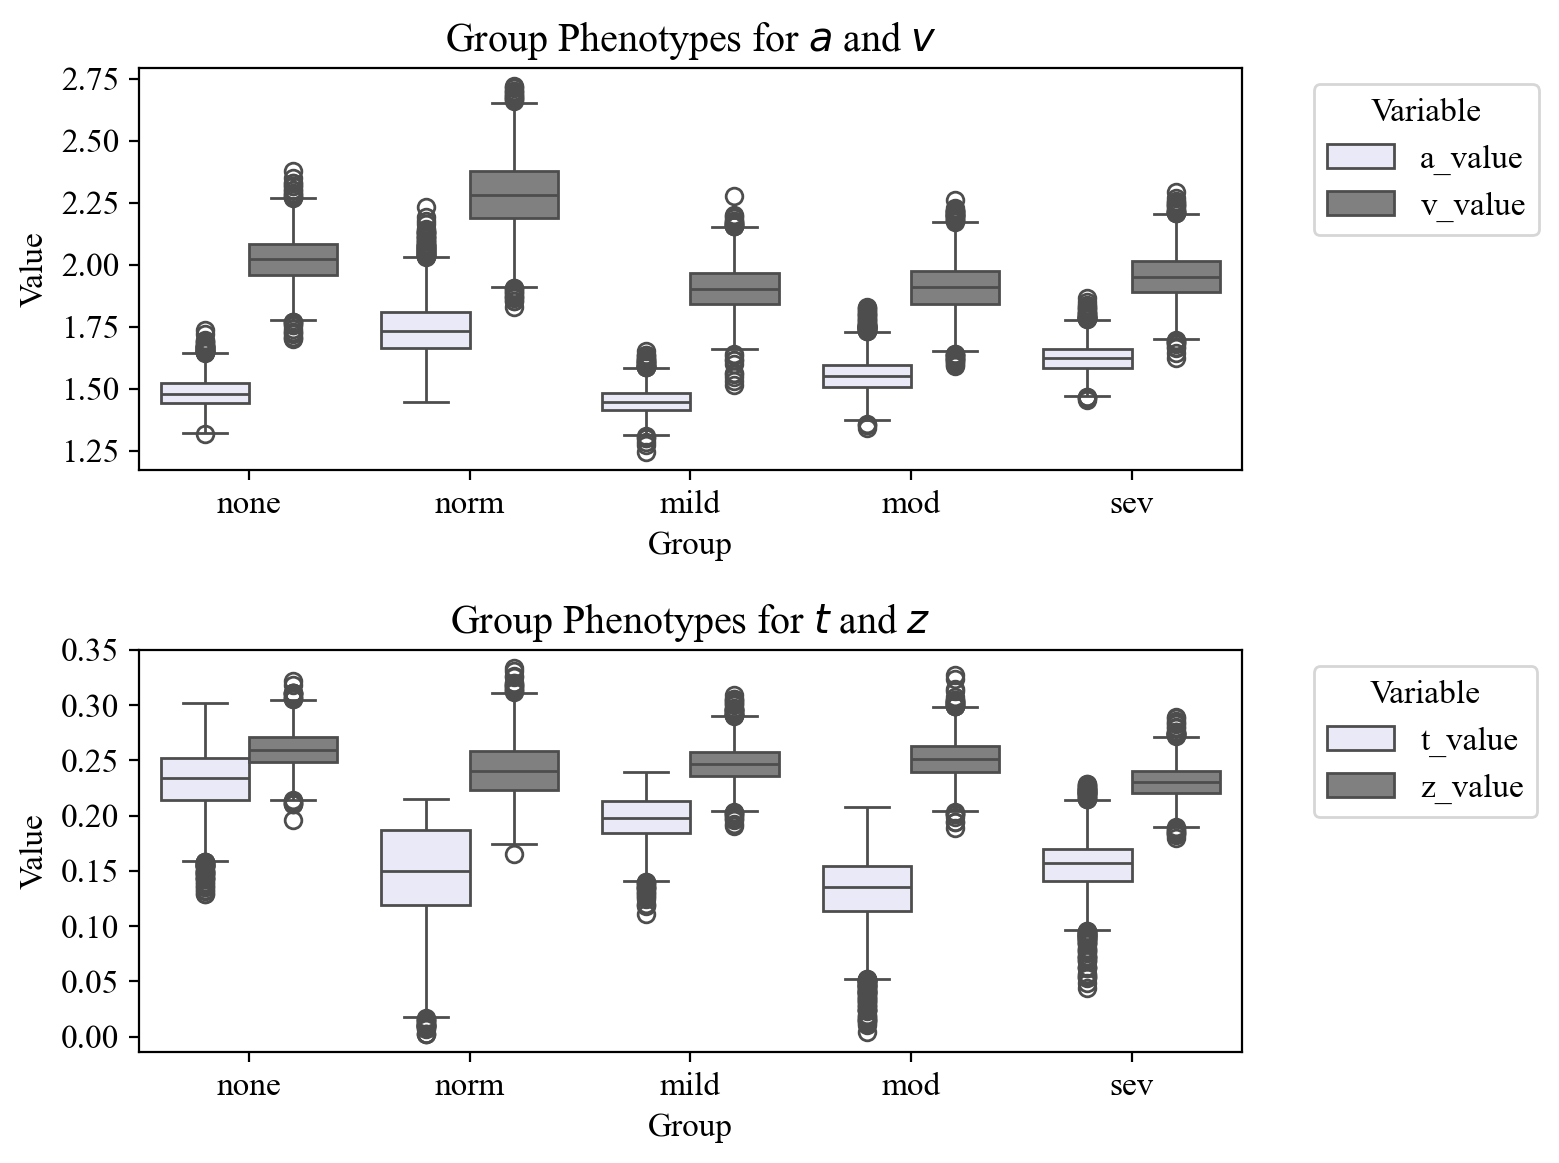

In [159]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import MultipleLocator

# Set font and figure size
plt.rcParams.update({'font.size': 12, 'font.family': 'Times New Roman'})
fig, axes = plt.subplots(2, 1, figsize=(8, 6))

# Create grouped boxplot for 'a_value' and 'v_value'
sns.boxplot(x='group', y='value', hue='variable', 
            data=pd.melt(all_group_data, id_vars=['group'], value_vars=['a_value', 'v_value']),
            ax=axes[0], palette={'a_value': 'lavender', 'v_value': 'gray'})
axes[0].set_xlabel('Group')
axes[0].set_ylabel('Value')
axes[0].set_title('Group Phenotypes for $a$ and $v$')
axes[0].legend(title='Variable', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0].yaxis.set_major_locator(MultipleLocator(0.25))

# Create grouped boxplot for 't_value' and 'z_value' with specified colors
sns.boxplot(x='group', y='value', hue='variable', 
            data=pd.melt(all_group_data, id_vars=['group'], value_vars=['t_value', 'z_value']),
            ax=axes[1], palette={'t_value': 'lavender', 'z_value': 'gray'})
axes[1].set_xlabel('Group')
axes[1].set_ylabel('Value')
axes[1].set_title('Group Phenotypes for $t$ and $z$')
axes[1].legend(title='Variable', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1].yaxis.set_major_locator(MultipleLocator(0.05))

# Adjust layout
plt.tight_layout()

# Save Fig
plt.savefig('all_params.png')

# Show the plots
plt.show()

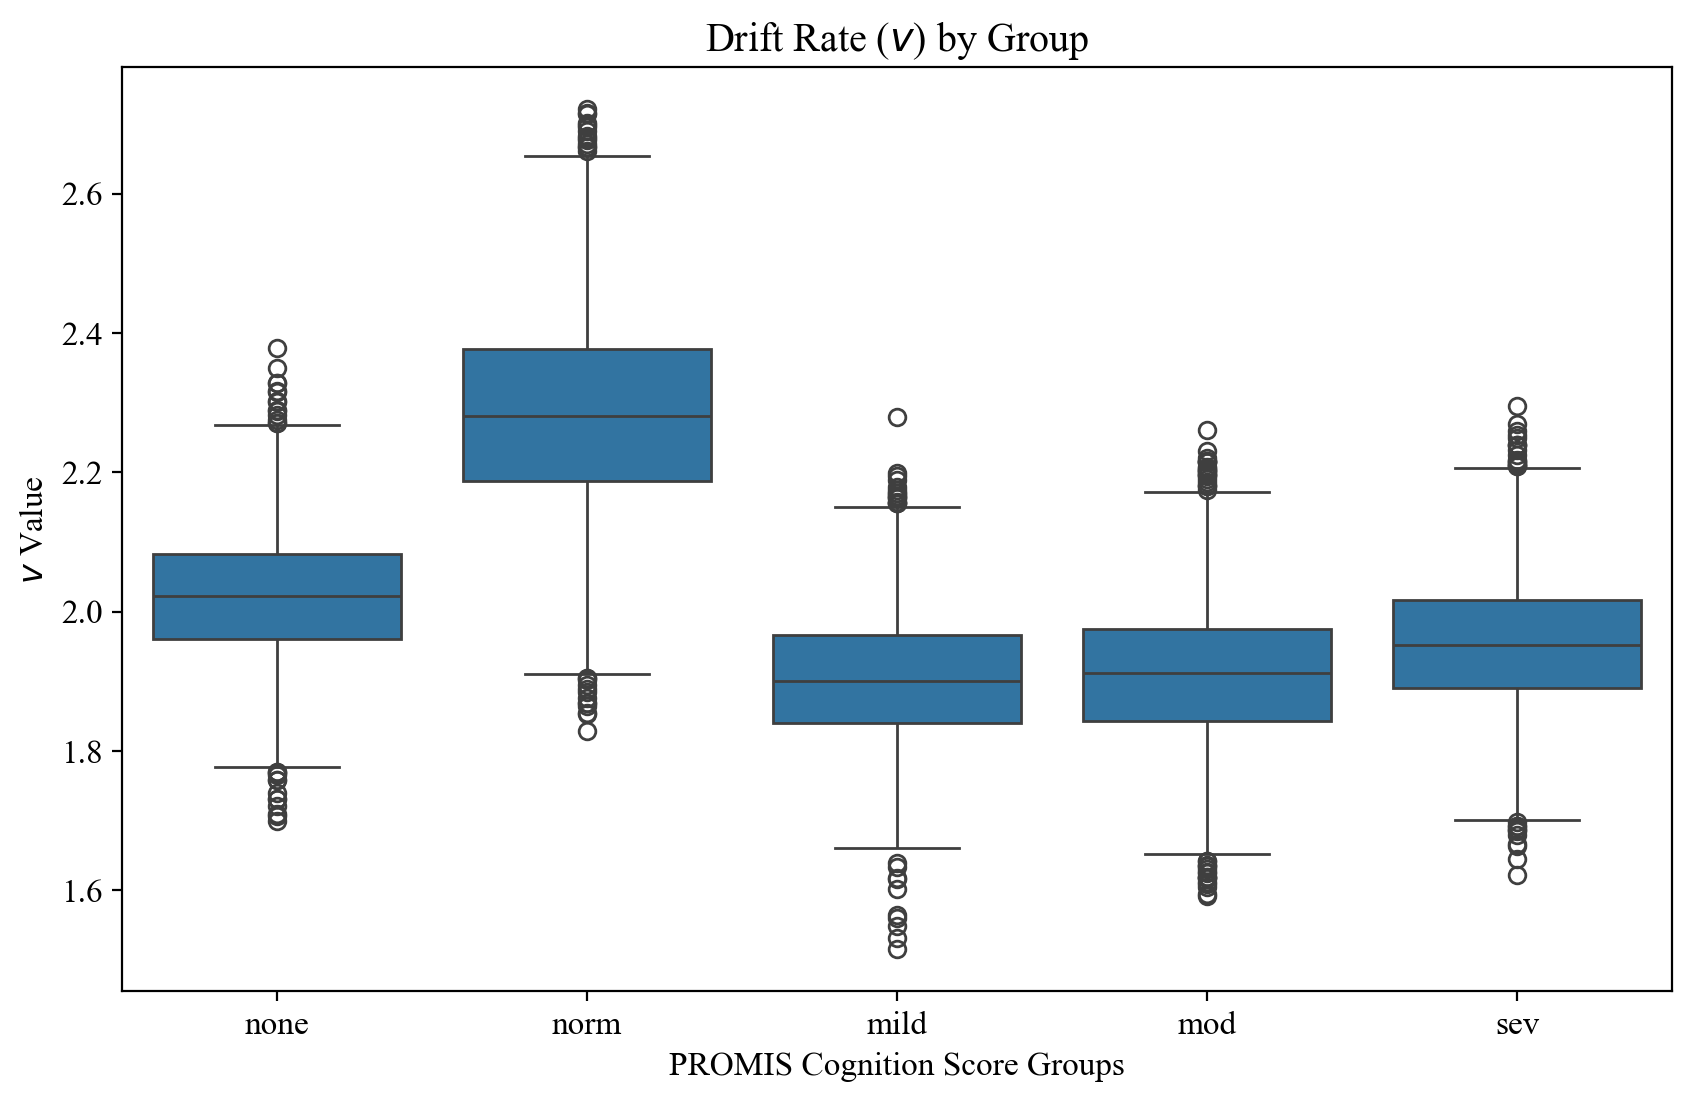

In [161]:
plt.rcParams.update({'font.size': 12, 'font.family': 'Times New Roman'})
plt.figure(figsize=(10, 6))
sns.boxplot(x='group', y='v_value', data=data_v)
plt.xlabel('PROMIS Cognition Score Groups')
plt.ylabel('$v$ Value')
plt.title('Drift Rate ($v$) by Group')
plt.savefig('v_boxplot.png')
plt.show()

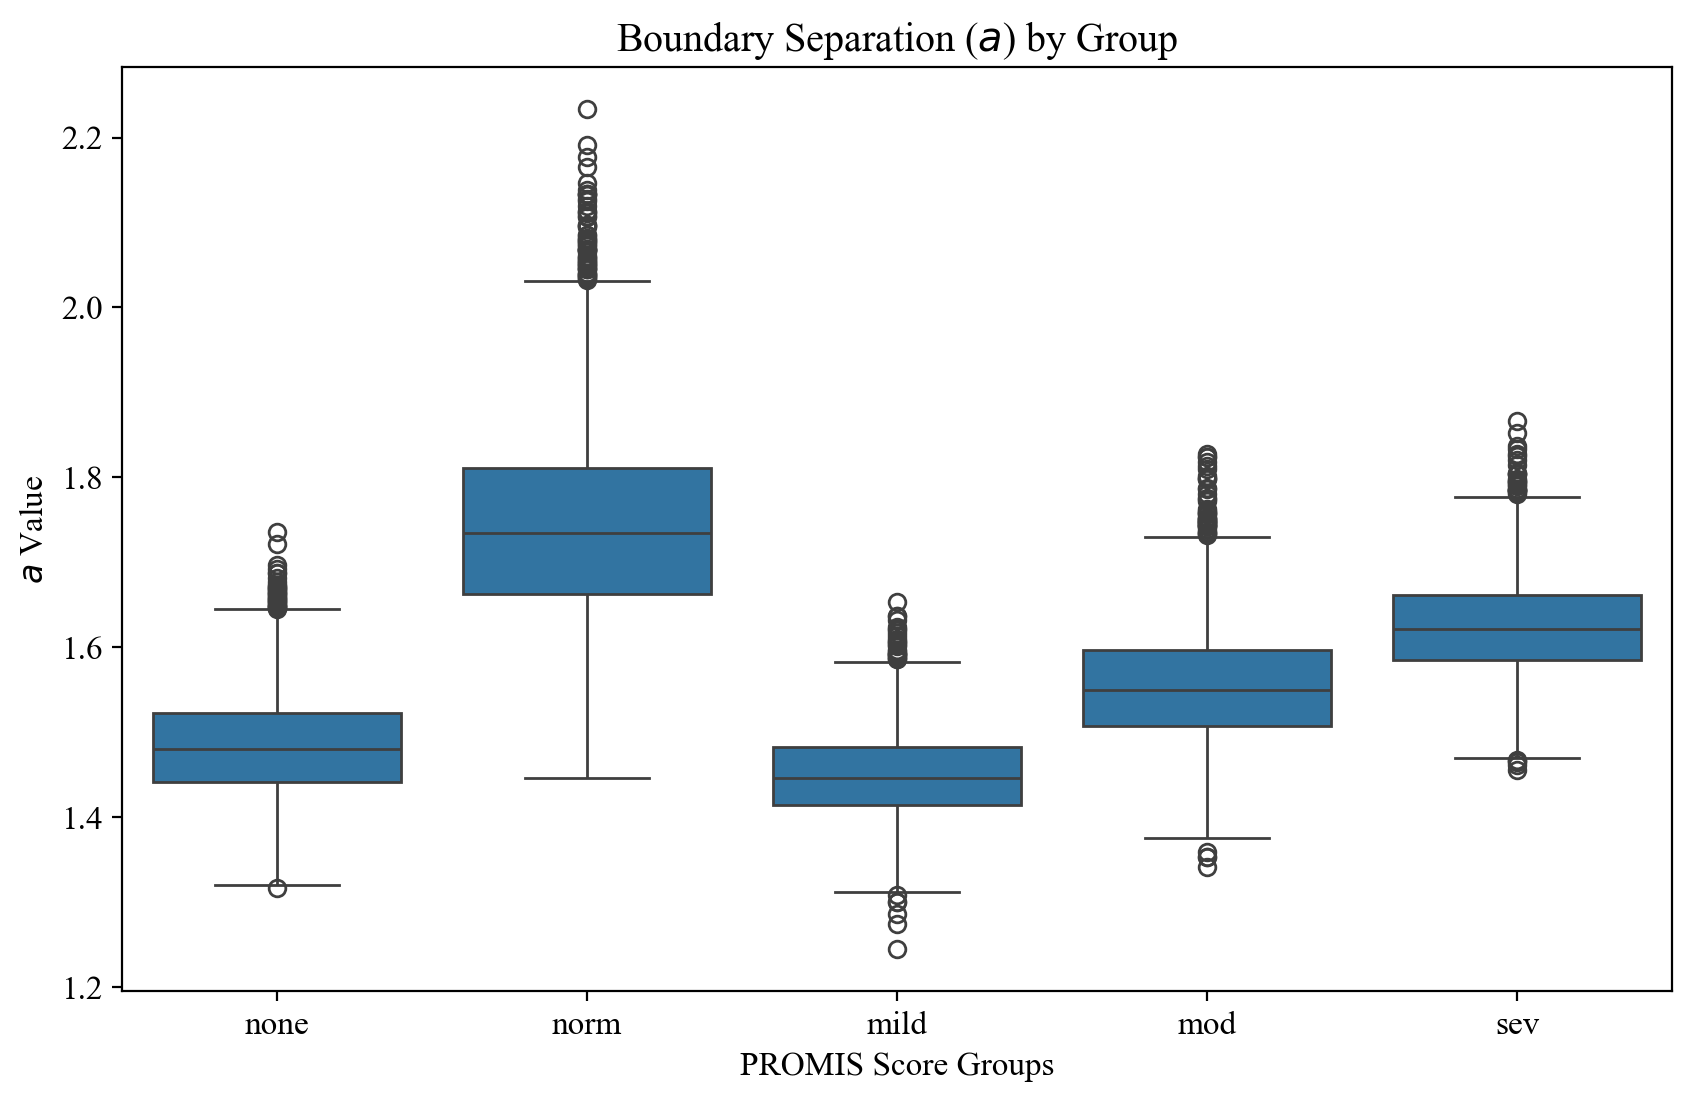

In [162]:
plt.rcParams.update({'font.size': 12, 'font.family': 'Times New Roman'})
plt.figure(figsize=(10, 6))
sns.boxplot(x='group', y='a_value', data=data_a)
plt.xlabel('PROMIS Score Groups')
plt.ylabel('$a$ Value')
plt.title('Boundary Separation ($a$) by Group')
plt.savefig('a_boxplot.png')
plt.show()

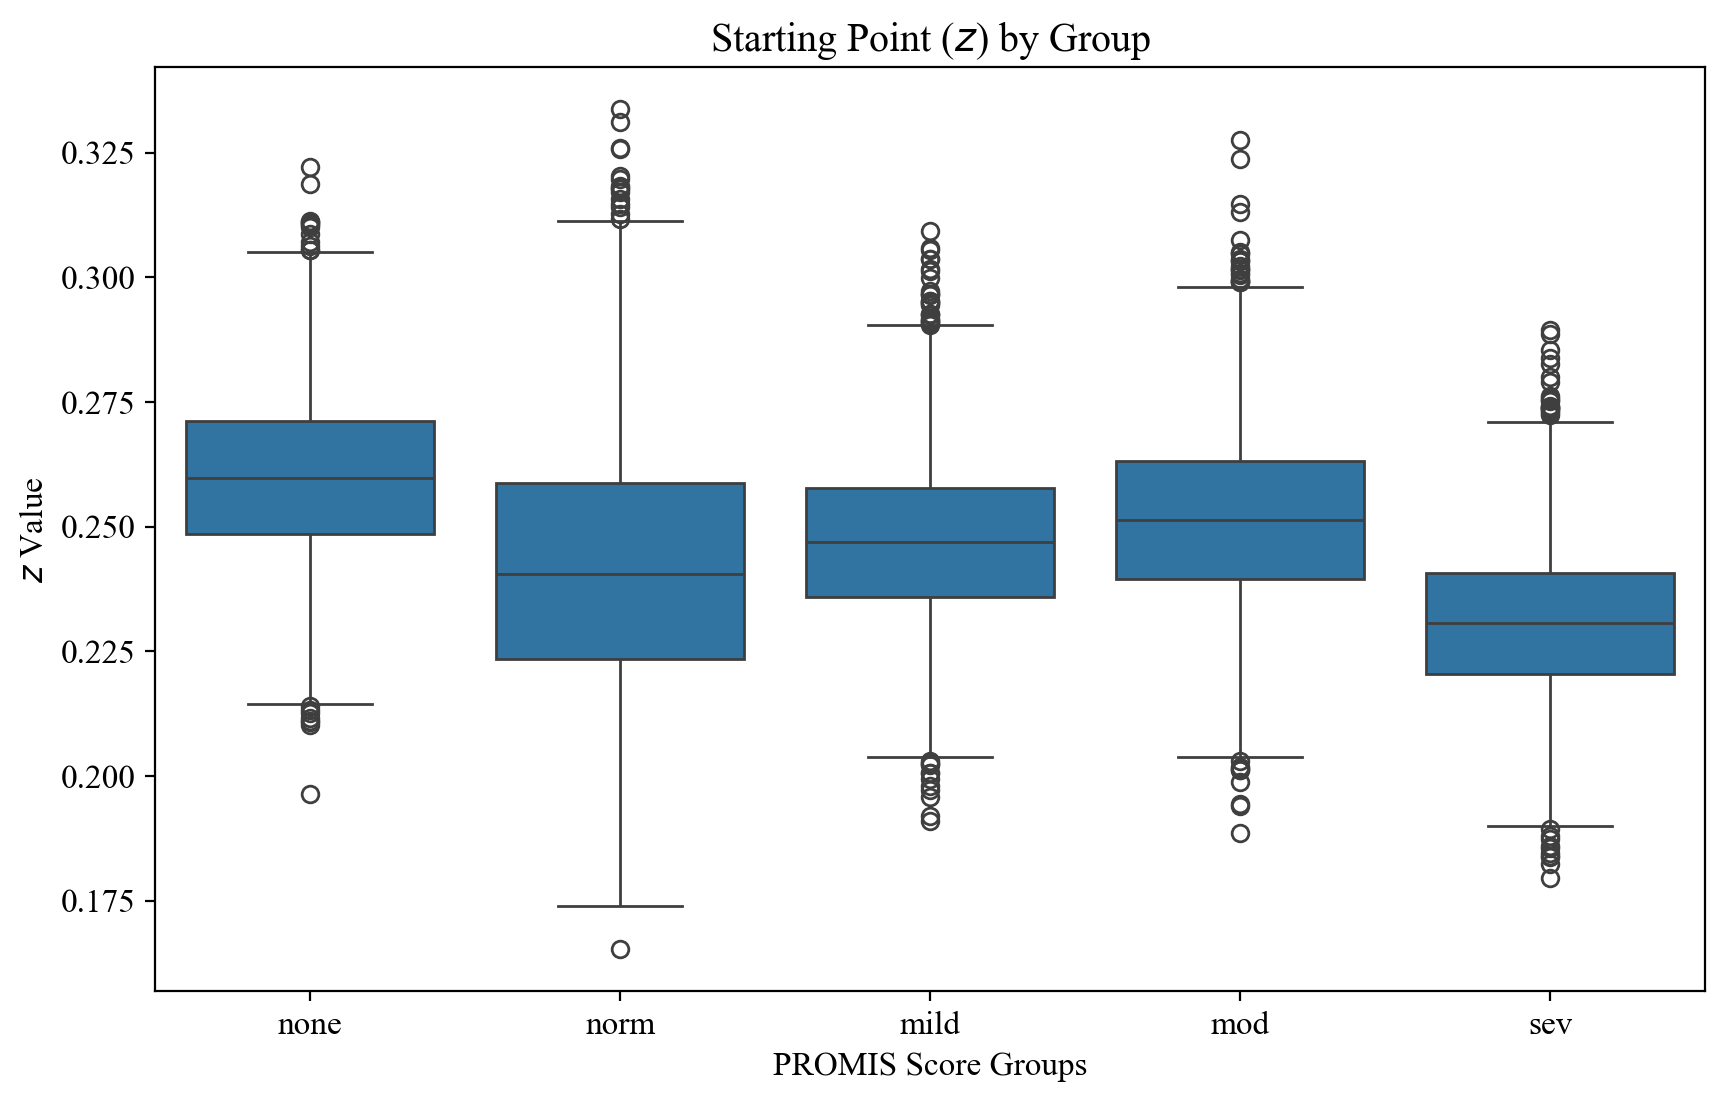

In [163]:
plt.rcParams.update({'font.size': 12, 'font.family': 'Times New Roman'})
plt.figure(figsize=(10, 6))
sns.boxplot(x='group', y='z_value', data=data_z)
plt.xlabel('PROMIS Score Groups')
plt.ylabel('$z$ Value')
plt.title('Starting Point ($z$) by Group')
plt.savefig('z_boxplot.png')
plt.show()

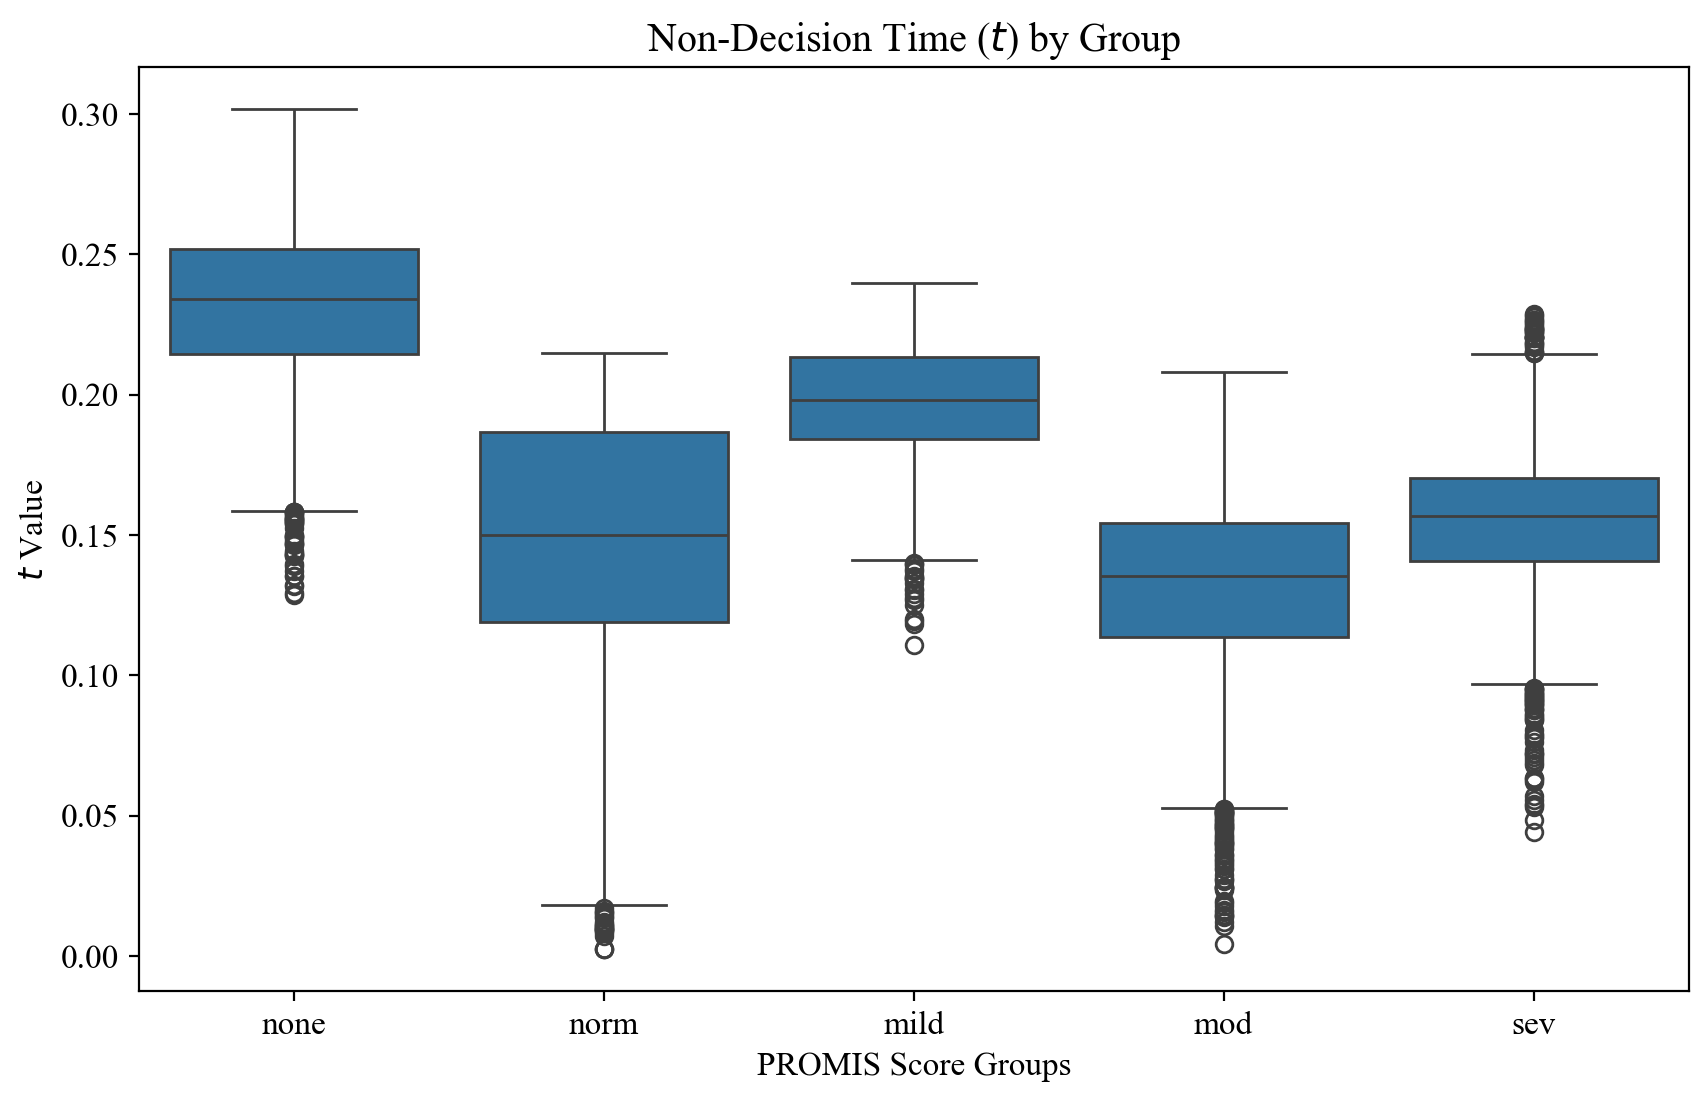

In [164]:
plt.rcParams.update({'font.size': 12, 'font.family': 'Times New Roman'})
plt.figure(figsize=(10, 6))
sns.boxplot(x='group', y='t_value', data=data_t)
plt.xlabel('PROMIS Score Groups')
plt.ylabel('$t$ Value')
plt.title('Non-Decision Time ($t$) by Group')
plt.savefig('t_boxplot.png')
plt.show()